In [1]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
import sys
from pprint import pprint

sys.path.append('../..')

In [109]:
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, usd_price, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices
from datetime import datetime
import math
import random

initial_omnipool_tvl = 10000000
lrna_price_usd = 22.22

omnipool = OmnipoolState(
    tokens={
        'DOT': {'liquidity': 1000000, 'LRNA': 1000000},
        'HDX': {'liquidity': 100000000, 'LRNA': 1000000},
        'USD': {'liquidity': 10000000, 'LRNA': 10000000}
    },
    lrna_fee=0,
    asset_fee=0,
    preferred_stablecoin = 'USD',
)

agent1 = Agent(
    holdings={'DOT': 1}
)
agent2 = Agent(
    holdings={'DOT': 2}
)
agent3 = Agent(
    holdings={'DOT': 3000003, 'HDX': 100000000}
)
initial_state = GlobalState(
    pools={
        'omnipool': omnipool
    },
    agents={
        'LP1': agent1,
        'LP2': agent2
    }
)

In [110]:
print(omnipool.usd_price(omnipool, 'DOT'))
omnipool.add_liquidity(
    agent=agent1,
    quantity=1,
    tkn_add='DOT'
)
print(agent1.holdings)
omnipool.swap(
    agent=agent3,
    tkn_sell='DOT',
    tkn_buy='HDX',
    sell_quantity = 1000001
)
print(agent1.holdings)


1.0
{'DOT': 0, 'HDX': 0, 'USD': 0, ('omnipool', 'DOT'): 1.0}
{'DOT': 0, 'HDX': 0, 'USD': 0, ('omnipool', 'DOT'): 1.0}


In [111]:
print(omnipool.usd_price(omnipool, 'DOT'))
omnipool.add_liquidity(
    agent=agent2,
        quantity=2,
    tkn_add='DOT'
)
print(agent2.holdings)

0.25
{'DOT': 0, 'HDX': 0, 'USD': 0, ('omnipool', 'DOT'): 1.0}


In [112]:
print(agent1, agent2)


Agent: LP1
********************************
trade strategy: None
holdings: (

    *DOT*: 0

    *HDX*: 0

    *USD*: 0

    *('omnipool', 'DOT')*: 1.0
    price: 1.0
)
 Agent: LP2
********************************
trade strategy: None
holdings: (

    *DOT*: 0

    *HDX*: 0

    *USD*: 0

    *('omnipool', 'DOT')*: 1.0
    price: 0.25
)



In [148]:
price_scenarios = []
for n in range(99, 0, -1):
    tkn_sell = 'HDX'
    tkn_buy = 'DOT'
    sell_quantity = agent3.holdings['HDX'] / 100 * n
    price_scenarios.append(
        omnipool.copy().swap(
            agent=agent3.copy(),
            tkn_sell=tkn_sell,
            tkn_buy=tkn_buy,
            sell_quantity=sell_quantity
        )
    )
price_scenarios.append(omnipool.copy())
for n in range(0, 99):
    tkn_sell = 'DOT'
    tkn_buy = 'HDX'
    sell_quantity = agent3.holdings['DOT'] / 100 * n
    price_scenarios.append(
        omnipool.copy().swap(
            agent=agent3.copy(),
            tkn_sell=tkn_sell,
            tkn_buy=tkn_buy,
            sell_quantity=sell_quantity
        )
    )

In [149]:
agent1_value = [
    cash_out_omnipool(omnipool=pool, agent=agent1, prices={tkn: usd_price(pool, tkn) for tkn in pool.asset_list})
    for pool in price_scenarios
]
agent2_value = [
    cash_out_omnipool(omnipool=pool, agent=agent2, prices={tkn: usd_price(pool, tkn) for tkn in pool.asset_list})
    for pool in price_scenarios
]

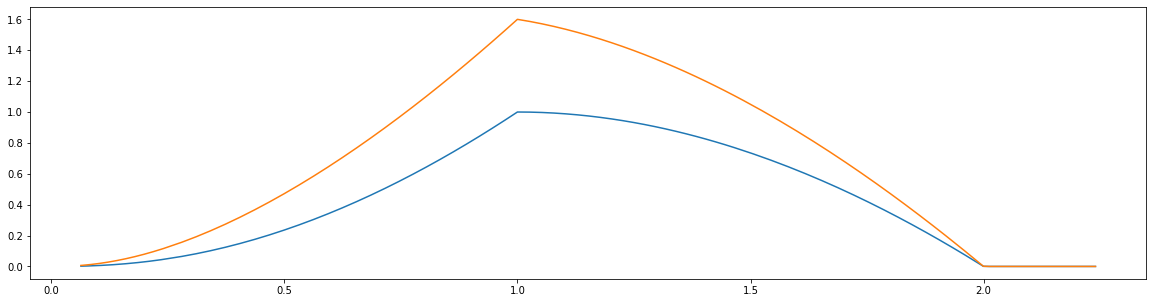

In [150]:
plt.figure(figsize=(20, 5))
prices = [usd_price(pool, 'DOT') for pool in price_scenarios]
plt.plot(prices, agent1_value)
plt.plot(prices, agent2_value)
plt.xl

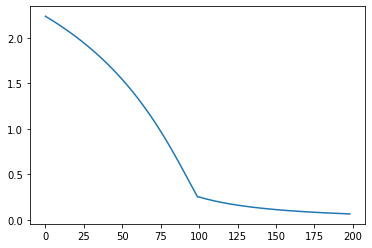

In [151]:
prices = [usd_price(pool, 'DOT') for pool in price_scenarios]
plt.plot(prices)